신경망의 예측 성능 및 수렴 성능을 개선하기 위해서는 다음과 같은 추가적인 고려를 해야 한다.

* 크로스 엔트로피(cross-entropy) 오차함수
* hyper-tangent and ReLu 활성화 함수
* 가중치 초기값 정규화(Weight normalizatio )
* Drop-out 정규화(Regularization)
* Softmax 출력
* 배치 정규화(Batch Normalization)

### 1. 크로스 엔트로피 오차함수

크로스 엔트로피(Cross-Entropy) 형태의 오차함수를 사용하면 출력 레이어에서 활성화 함수의 도함수에 의한 영향을 제거할 수 있다.

\begin{eqnarray} 
  C = y \log z^{(L)} + (1-y) \log (1-z^{(L)})
\end{eqnarray}

이 경우 출력 레이어의 가중치에 대한 미분값은 다음과 같아진다.

\begin{eqnarray}
\frac{\partial C}{\partial w_j^{(L)}} 
&=& \left(\frac{y }{z^{(L)}} - \frac{(1-y)}{1-z^{(L)}} \right) \frac{\partial z^{(L)}}{\partial w_j^{(L)}} \\
&=& \left(\frac{y}{\sigma(a)} - \frac{(1-y)}{1-\sigma(a)} \right)\sigma'(a) z^{(l-1)}_j \\
&=& \frac{\sigma'(a) }{\sigma(a) (1-\sigma(a))} (\sigma(a)-y) z^{(l-1)}_j  \\
&=& (\sigma(a)-y) z^{(l-1)}_j \\ 
&=& (z^{(L)}-y) z^{(l-1)}_j \\ 
\\
\frac{\partial C}{\partial b^{(L)}} &=&  z^{(L)} - y
\end{eqnarray}

### Keras 에서 크로스 엔트로피 사용¶
Keras에서는 compile 메서드의 **loss 인수**를 설정하여 **크로스 엔트로피를 포함한 다양한 오차함수를 사용할 수 있다**. loss 인수에서 설정 가능한 값 중 몇 가지 예를 들면 다음과 같다.

* mean_squared_error
* mean_squared_logarithmic_error
* mean_absolute_error
* mean_absolute_percentage_error
* binary_crossentropy
* categorical_crossentropy

In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

In [2]:
(X_train0, y_train0), (X_test0, y_test0) = mnist.load_data()

X_train = X_train0.reshape(-1, 28*28).astype('float32') / 255.0
X_test = X_test0.reshape(-1, 28*28).astype('float32') / 255.0
Y_train = np_utils.to_categorical(y_train0, 10)
Y_test = np_utils.to_categorical(y_test0, 10)

import numpy as np
np.random.seed(0)
model0 = Sequential()
model0.add(Dense(15, input_dim=28*28, activation='sigmoid'))
model0.add(Dense(10, activation='sigmoid'))
model0.compile(optimizer=SGD(lr=0.2), loss='mean_squared_error', metrics=['accuracy'])

In [3]:
%%time
hist0 = model0.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 44.1 s, sys: 4.85 s, total: 48.9 s
Wall time: 34.2 s


In [4]:
np.random.seed(0)
model1 = Sequential()
model1.add(Dense(15, input_dim=28*28, activation='sigmoid'))
model1.add(Dense(10, activation='sigmoid'))
model1.compile(optimizer=SGD(lr=0.2), loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
%%time
hist1 = model1.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 42.3 s, sys: 5.79 s, total: 48.1 s
Wall time: 28.7 s


In [7]:
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pylab as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 12

path = "/Library/Fonts/NanumGothic.otf"
font_name = fm.FontProperties(fname=path, size=20).get_name()

plt.rc('font', family=font_name)
fm._rebuild()

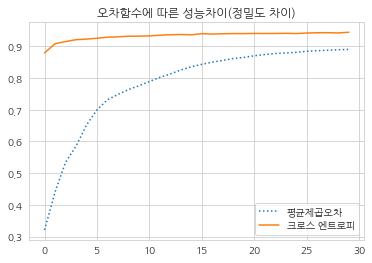

In [9]:
plt.plot(hist0.history['val_acc'], ls=":", label="평균제곱오차")
plt.plot(hist1.history['val_acc'], label="크로스 엔트로피")
plt.legend()
plt.title("오차함수에 따른 성능차이(정밀도 차이)")
plt.show()

### 2. 하이퍼탄젠트 활성화 함수

활성화 함수로 로지스틱 함수 대신 하이퍼탄젠트(Hypertangent)를 사용하면 도함수의 최댓값이 로지스틱 함수의 4배인 1이 되므로 그레디언트 감소 현상이 줄어든다.

\begin{eqnarray}
  \tanh(a) \equiv \frac{e^a-e^{-a}}{e^a+e^{-a}} = 2\sigma(2a) - 1
\end{eqnarray}

In [10]:
def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1 - np.tanh(x) ** 2

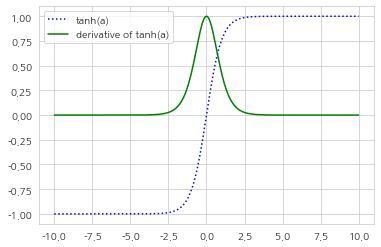

In [11]:
xx = np.linspace(-10, 10, 1000)
plt.plot(xx, tanh(xx), 'b:', label="tanh(a)")
plt.plot(xx, tanh_prime(xx), 'g-', label="derivative of tanh(a)")
plt.legend()
plt.show()

### 3. Rectified Linear Unit (ReLu) 활성화 함수

가장 좋은 방법은 Rectified Linear Unit (ReLu) 활성화 함수를 사용하는 것이다. ReLu는 가중치 총합  𝑎 가 큰 경우에도 기울기(gradient)가 1로 유지되므로  𝑎 이 커도 그레디언트 감소 현상이 발생하지 않는다. CNN과 같이 레이어의 수가 많은 경우에 유용하다.

\begin{eqnarray}
  \max(0, a)
\end{eqnarray}

𝑎 가 음수인 경우에도 기울기가 0이 되지 않도록 하는 Leaky ReLu도 사용한다.

\begin{eqnarray}
  \max(\alpha a, a) \;\; (0 < \alpha < 1)
\end{eqnarray}

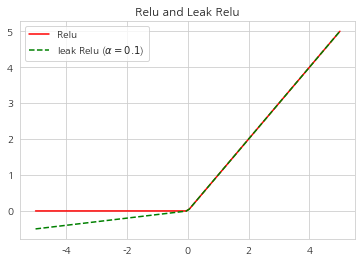

In [12]:
a = np.linspace(-5, 5, 100)
relu = np.maximum(0, a)
leakrelu = np.maximum(0.1 * a, a)
plt.plot(a, relu, 'r-', label='Relu')
plt.plot(a, leakrelu, 'g--', label='leak Relu ($\\alpha=0.1$)')
plt.title("Relu and Leak Relu")
plt.legend()
plt.show()

Keras에서는 Dense 네트워크를 생성할 때 activation 인수의 값을 바꿀 수 있다.

* sigmoid
* tanh
* relu

In [13]:
np.random.seed(0)
model2 = Sequential()
model2.add(Dense(15, input_dim=28*28, activation='tanh'))
model2.add(Dense(10, activation='sigmoid'))
model2.compile(optimizer=SGD(lr=0.2), loss='mean_squared_error', metrics=['accuracy'])

In [15]:
%%time
hist2 = model2.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30, batch_size=100, verbose=0)

CPU times: user 36.9 s, sys: 4.98 s, total: 41.9 s
Wall time: 24.5 s


In [16]:
np.random.seed(0)
model3 = Sequential()
model3.add(Dense(15, input_dim=28*28, activation='relu'))
model3.add(Dense(10, activation='sigmoid'))
model3.compile(optimizer=SGD(lr=0.2), loss='mean_squared_error', metrics=['accuracy'])

In [17]:
%%time
hist3 = model3.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 41.8 s, sys: 5.06 s, total: 46.9 s
Wall time: 31 s


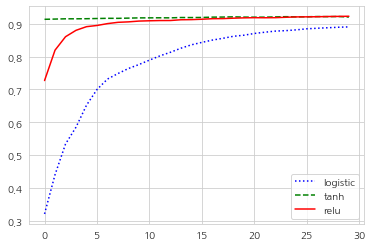

In [18]:
plt.plot(hist0.history['val_acc'], 'b:', label='logistic')
plt.plot(hist2.history['val_acc'], 'g--', label='tanh')
plt.plot(hist3.history['val_acc'], 'r-', label='relu')
plt.legend()
plt.show()

성능이 tahn 가 가장 빠르게 높은 정밀도에 수렴된다.

### 4. 초기 가중치 정규화

활성화값  𝑎 는 입력변수 벡터  𝑥 와 가중치 벡터  𝑤 의 내적이다.

$$a = w^Tx$$

가중치 벡터  𝑤 의 초기값은 가우시안 정규 분포 또는 유니폼 분포에 따라 무작위로 설정하는데

정규분포 표본의 합의 표준편차는 표본 수의 제곱근에 비례하므로 입력변수 벡터  𝑥 의 차원이 증가하면 활성화값  𝑎  값의 표준편차(standard deviation)도 증가한다.

$$\text{std}(a) \propto \sqrt{n_{in}}$$

예를 들어 1000개의 픽셀로 이루어진 이미지 입력을 사용하는 경우를 가정해 보자. 만약 이미지를 구성하는 픽셀의 절반 정도가 1(검은색)이라는 값을 가지고 나머지 절반 정도가 0(흰색)을 가진다면 활성화값  𝑎 는 500개의 가우시안 정규 분포 표본의 합이 된다. 약 22.4이다.

$$\sqrt{500} \approx 22.4$$

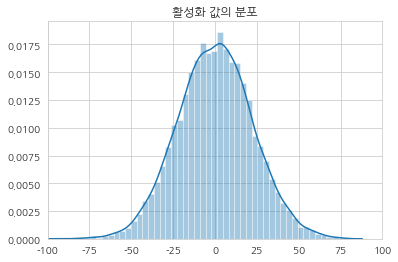

In [22]:
np.random.seed(0)
sns.distplot(np.random.randn(500, 10000).sum(axis=0)) # shape=(500, 10000) 가우시안 분포
plt.title("활성화 값의 분포")
plt.xlim(-100, 100)
plt.show()

**이렇게 표준 편차가 크면 수렴이 느려지기 때문에 입력 수에 따라 초기화 가중치의 표준편차를 감소하는 초기화 값 조정이 필요하다.** 2010년 Xavier Glorot는 반복 실험을 통해 다음과 같은 폭을 가진 유니폼 분포를 추천하였다.

$$w \sim \text{uniform}(-\text{limit},\text{limit})$$

$$\text{limit} = \sqrt{\dfrac{6}{(n_{\text{in}} + n_{\text{out}})}}$$

Keras에서는 **kernel_initializer** 인수로 가중치 초기화 방법을 바꿀 수 있다. 가능한 인수는 다음과 같은 것들이 있다.

* random_uniform
* random_normal
* glorot_uniform
* glorot_normal
* lecun_uniform
* lecun_normal

In [30]:
np.random.seed(0)

model4 = Sequential()
model4.add(Dense(100, kernel_initializer='normal', activation='sigmoid', input_dim=28*28))
model4.add(Dense(10, kernel_initializer='normal', activation='sigmoid'))
model4.compile(optimizer=SGD(lr=0.2), loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
%%time
hist4 = model4.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 1min 22s, sys: 7.51 s, total: 1min 29s
Wall time: 45.1 s


In [32]:
np.random.seed(0)
model5 = Sequential()
model5.add(Dense(100, kernel_initializer='glorot_uniform', input_dim=28*28, activation='sigmoid'))
model5.add(Dense(10, kernel_initializer='glorot_uniform', activation='sigmoid'))
model5.compile(optimizer=SGD(lr=0.2), loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
%%time
hist5 = model5.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 1min 21s, sys: 7.52 s, total: 1min 29s
Wall time: 44.2 s


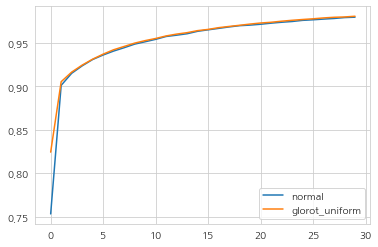

In [34]:
plt.plot(hist4.history['acc'], label='normal')
plt.plot(hist5.history['acc'], label='glorot_uniform')
plt.legend()
plt.show()

### 5. 과최적화 문제

신경망 모형은 파라미터의 수가 다른 모형에 비해 많다. 이렇게 파라미터의 수가 많으면 과최적화 발생 가능성이 증가한다. 즉, 정확도가 나아지지 않거나 나빠져도 오차 함수는 계속 감소하는 현상이 발생한다.

In [35]:
np.random.seed(0)
model6 = Sequential()
model6.add(Dense(30, input_dim=28*28, activation='sigmoid'))
model6.add(Dense(10, activation='sigmoid'))
model6.compile(optimizer=SGD(lr=0.5), loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
%%time
hist6 = model6.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 55.7 s, sys: 6.66 s, total: 1min 2s
Wall time: 34.6 s


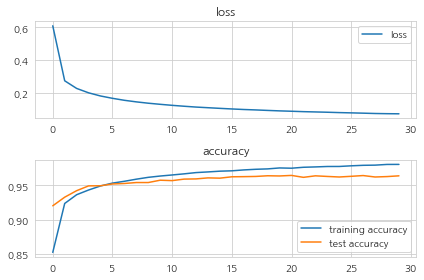

In [38]:
plt.subplot(211)
plt.plot(hist6.history['loss'], label='loss')
plt.legend()
plt.title('loss')
plt.subplot(212)
plt.plot(hist6.history['acc'], label='training accuracy')
plt.plot(hist6.history['val_acc'], label='test accuracy')
plt.legend()
plt.title("accuracy")
plt.tight_layout()
plt.show()

test 정밀도가 트레이닝 정밀도가 낮다는 것은 과최적화의 문제이다.

### L1, L2 정규화 : 오차함수의 정규화(일반화)

L1 정규화는 오차 함수에 가중치 행렬의 L1 놈을 추가하는 방법이다.

$$C = - (y \log z+(1-y) \log(1-z)) + \lambda \sum_i |w_i|$$

L2 정규화는 오차 함수에 가중치 행렬의 L2 놈을 추가한다.

$$C = - (y \log z+(1-y) \log(1-z)) + \lambda \sum_i w_i^2$$

Keras에서는 레이어 생성시에 kernel_regularizer 인수로 regularizers 서브패키지의 l1, l2 regularizer 객체를 넣어서 L1, L2 정규화를 구현한다.

In [39]:
from keras import regularizers

np.random.seed(0)
model7 = Sequential()
model7.add(Dense(30, input_dim=28*28, kernel_regularizer=regularizers.l2(0.001), activation='sigmoid'))
model7.add(Dense(10, activation='sigmoid'))
model7.compile(optimizer=SGD(lr=0.5), loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
%%time
hist7 = model7.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 57.6 s, sys: 7.09 s, total: 1min 4s
Wall time: 35.5 s


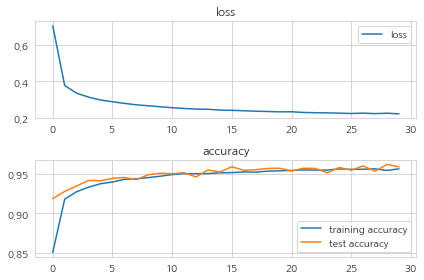

In [42]:
plt.subplot(211)
plt.plot(hist7.history['loss'], label='loss')
plt.legend()
plt.title('loss')
plt.subplot(212)
plt.plot(hist7.history['acc'], label='training accuracy')
plt.plot(hist7.history['val_acc'], label='test accuracy')
plt.legend()
plt.title('accuracy')
plt.tight_layout()
plt.show()

트레인닝 성능과 테스트 성능이 비슷해졌다.

### Dropout 정규화

Dropout 정규화 방법은 이러한 문제를 해결하기 위해 에포크 마다 임의의 은닉계층 뉴런의  𝑝 %를(보통 절반) dropout 하여 최적화 과정에 포함하지 않는 방법이다. 이 방법을 사용하면 가중치 값들이 특정한 뉴런에만 집중되는 것을 방지하여 정규화 효과를 가져다 준다.

[그림] Dropout: https://datascienceschool.net/upfiles/88b2bf7f587a493d99c6f27c06731bf3.png

테스트 시점에는 가중치에  𝑝 를 곱하여 스케일링한다.

[그림] 트레이닝 / 테스트 시의 Dropout : https://datascienceschool.net/upfiles/49d909b76da1454f80592241633dbbcb.png

In [43]:
from keras.layers import Dropout

np.random.seed(0)
model8 = Sequential()
model8.add(Dense(30, input_dim=28*28, activation='sigmoid'))
model8.add(Dropout(0.1)) # 0.1만 사용
model8.add(Dense(10, activation='sigmoid'))
model8.compile(optimizer=SGD(lr=0.5), loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
%%time
hist8 = model8.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 1min, sys: 7.5 s, total: 1min 8s
Wall time: 37.9 s


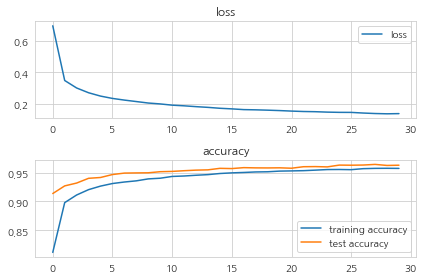

In [46]:
plt.subplot(211)
plt.plot(hist8.history['loss'], label='loss')
plt.legend()
plt.title('loss')
plt.subplot(212)
plt.plot(hist8.history['acc'], label='training accuracy')
plt.plot(hist8.history['val_acc'], label='test accuracy')
plt.legend()
plt.title('accuracy')
plt.tight_layout()
plt.show()

Dropout의 경우 test의 정밀도가 더 높다.

### 소프트맥스 출력

소프트맥스(softmax) 함수는 입력과 출력이 다변수(multiple variable) 인 함수이다. 최고 출력의 위치를 변화하지 않으면서 츨력의 합이 1이 되도록 조정하기 때문에 출력에 확률론적 의미를 부여할 수 있다. 보통 신경망의 최종 출력단에 적용한다.

\begin{eqnarray} 
  y^L_j = \frac{e^{a^L_j}}{\sum_k e^{a^L_k}},
\end{eqnarray}

\begin{eqnarray}
  \sum_j y^L_j & = & \frac{\sum_j e^{a^L_j}}{\sum_k e^{a^L_k}} = 1
\end{eqnarray}

In [47]:
from ipywidgets import interactive
from IPython.display import Audio, display

In [48]:
def softmax_plot(z1=0, z2=0, z3=0, z4=0):
    exps = np.array([np.exp(z1), np.exp(z2), np.exp(z3), np.exp(z4)])
    exp_sum = exps.sum()
    plt.bar(range(len(exps)), exps/exp_sum, align='center') # 확률 p 
    plt.ylim(0, 1)
    plt.xticks([])
    
    
v = interactive(softmax_plot, z1=(-3, 5, 0.01), z2=(-3, 5, 0.01), z3=(-3, 5, 0.01), z4=(-3, 5, 0.01))
display(v)

interactive(children=(FloatSlider(value=0.0, description='z1', max=5.0, min=-3.0, step=0.01), FloatSlider(valu…

**Keras에서 출력단의 소프트맥스 활성화 함수는 activation 인수의 값을 "softmax"로 지정하여 구현한다.**

In [49]:
np.random.seed(0)
model9 = Sequential()
model9.add(Dense(15, input_dim=28*28, activation='sigmoid', kernel_initializer='glorot_uniform')) 
model9.add(Dense(10, activation='softmax', kernel_initializer='glorot_uniform'))
model9.compile(optimizer=SGD(lr=0.2), loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
%%time
hist9 = model9.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)

CPU times: user 1min 46s, sys: 17.4 s, total: 2min 4s
Wall time: 1min 12s


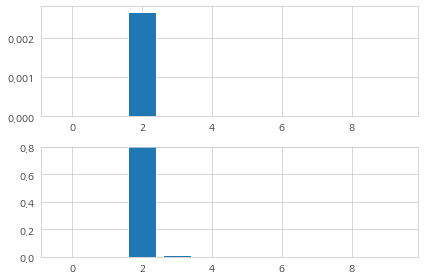

In [53]:
k = 1
y8 = model8.predict(X_test[k:k+1, :])[0]
y9 = model9.predict(X_test[k:k+1, :])[0]

plt.subplot(211)
plt.bar(range(len(y8)), y8, align='center')
plt.subplot(212)
plt.bar(range(len(y9)), y9, align='center')
plt.ylim(0, 0.8)
plt.tight_layout()
plt.show()

In [56]:
y8.sum()

0.0027136158

In [57]:
y9.sum()

0.99999994

### 배치 정규화

배치 정규화(Batch Normalization)은 미니배치 만큼의 트레이닝이 끝날 때마다  𝑎 의 평균과 분산을 계산해서 평균 0, 분산 1이 되도록 스케일링을 해주고 학습하는 파라미터  𝛾,𝛽  를 각각 곱하고 더해준다.

[그림] 배치 정규화 : https://datascienceschool.net/upfiles/9da98154ea4044cea17a02fd5755cd57.png

Keras에서 배치 정규화는 레이어 뒤에 BatchNormalization 객체를 추가하여 구현한다. 다만 이 경우에는 활성화 함수를 BatchNormalization 객체 뒤에 명시적으로 추가해야 한다.

In [58]:
from keras.layers import Activation, BatchNormalization

np.random.seed(0)
model10 = Sequential()
model10.add(Dense(15, input_dim=28*28))
model10.add(BatchNormalization())
model10.add(Activation('sigmoid'))
model10.add(Dense(10))
model10.add(BatchNormalization())
model10.add(Activation('sigmoid'))
model10.compile(optimizer=SGD(lr=0.2), loss='mean_squared_error', metrics=['accuracy'])

In [59]:
%%time
hist10 = model10.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 1min 10s, sys: 13.9 s, total: 1min 24s
Wall time: 46.5 s


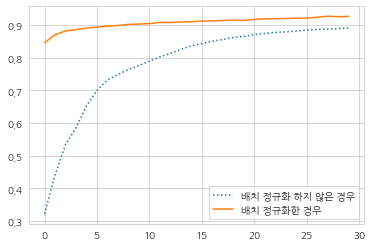

In [60]:
plt.plot(hist0.history['val_acc'], ls=":", label='배치 정규화 하지 않은 경우')
plt.plot(hist10.history['val_acc'], label="배치 정규화한 경우")
plt.legend()
plt.show()

배치 정규화한 경우 빠르게 성능이 높게 수렴한다.